In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 
import seaborn as sns
from numba import njit
from matplotlib.lines import Line2D
from scipy.signal import find_peaks

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [3]:
##### function creating opinion distribution #####
def opinion_dist(N, dist_type, dist_params):
    
    if dist_type == 'normal':
        exp_value = dist_params[0]
        std_deviation = dist_params[1]
        opinion = np.random.normal(exp_value, std_deviation, N) 
        return opinion
    elif dist_type == 'uniform':
        lower_border = dist_params[0]
        upper_border = dist_params[1]
        opinion = np.random.uniform(lower_border, upper_border, N) 
        return opinion
    elif dist_type == 'beta':
        alpha = dist_params[0]
        beta = dist_params[1]
        opinion = (np.random.beta(alpha, beta, N)-0.5)*2 
        return opinion
    else:
        print('unknown dist_type "%s"' %dist_type)
        return

##### opinion rule weight function #####
@njit
def f(opinion_a, opinion_b, mu, epsilon, scale, interaction_width):

    weight = mu*(1 - (1/epsilon)*abs(opinion_a - opinion_b))
    
    if abs(opinion_a - opinion_b) > interaction_width:
        return 0
    elif weight < 0:
        return weight/scale
    else:
        return weight   

@njit
def f_2(opinion_a, opinion_b, epsilon, mu):
    
    dist = abs(opinion_a - opinion_b)
    
    if dist == 0:
        weight = 0
    
    elif dist <= epsilon:
        weight = mu*(1-1/epsilon*dist)**100
    
    elif dist > epsilon:
        weight = -mu*(1/epsilon*dist-1)**100
            
    return weight
    
    
@njit
def RW(opinion_a, opinion_b, epsilon, mu):
    dist = abs(opinion_a - opinion_b)
    
    return mu * (1 - (dist/epsilon)**2) * np.exp(-0.5*(dist/epsilon)**2)
    
    
@njit    
##### opinion truncating function #####
def trunc_opinion(opinion, border, alpha, beta):
    reset = 0
    if opinion > border:
        new_opinion = np.random.beta(alpha, beta)
        reset = 1
    elif opinion < -border:
        new_opinion = -np.random.beta(alpha, beta)
        reset = 1
    else:
        new_opinion = opinion
    
    return new_opinion, reset

@njit    
def trunc_opinion_2(opinion):

    if opinion < -1:
        new_opinion = -1
    elif opinion > 1:
        new_opinion = 1
    else:
        new_opinion = opinion
    
    return new_opinion

@njit
##### opinion dynamics ##### 
def opinion_dynamics(opinion_dist_a, opinion_dist_b, simulation_time, parameter, freq_step):
    
    opinion_timeline = np.zeros((1000, int(simulation_time/freq_step)))
    
    reset_freq = np.zeros(int(simulation_time/freq_step))  
    save_reset = 0
    
    rejection_freq = np.zeros(int(simulation_time/freq_step))
    save_rejection = 0
    
    attraction_freq = np.zeros(int(simulation_time/freq_step))  
    save_attraction = 0
    
    ignorance_freq = np.zeros(int(simulation_time/freq_step))  
    save_ignorance = 0
    
    N_reset = 0
    
    all_weights = np.zeros(simulation_time)
    
    for i in range(simulation_time):
        x = np.random.randint(0, len(opinion_dist_a))
        y = np.random.randint(0, len(opinion_dist_b))

        opinion_a = opinion_dist_a[x]  
        opinion_b = opinion_dist_b[y]
        
        #weight = f(opinion_a, opinion_b, parameter[0], parameter[1], parameter[2], parameter[3])
        #weight = f_2(opinion_a, opinion_b, parameter[1], parameter[0])
        weight = RW(opinion_a, opinion_b, parameter[1], parameter[0])
        all_weights[i] = weight
        
        if weight < 0:
            random = np.random.rand()
            save_rejection += 1
            
            if random < parameter[4]:
                opinion_dist_a = np.delete(opinion_dist_a, x)
                new_opinion = np.random.normal(0, 0.22, int(parameter[5]))
                opinion_dist_a = np.concatenate((opinion_dist_a, new_opinion), axis=0)
                reset = 0
            
            else:
                opinion_dist_a[x] += weight*(opinion_b - opinion_a)
                #opinion_dist_a[x], reset = trunc_opinion(opinion_dist_a[x], parameter[6], parameter[7], parameter[8])
                #opinion_dist_a[x] = trunc_opinion_2(opinion_dist_a[x])

                
        elif weight > 0:
            opinion_dist_a[x] += weight*(opinion_b - opinion_a)
            #opinion_dist_a[x], reset = trunc_opinion(opinion_dist_a[x], parameter[6], parameter[7], parameter[8])
            #opinion_dist_a[x] = trunc_opinion_2(opinion_dist_a[x])

            save_attraction += 1
        
        else:
            save_ignorance += 1
        
        N_reset += reset
        save_reset += reset
        
        if i%freq_step == 0:
            reset_freq[int(i/freq_step)] = save_reset/freq_step
            save_reset = 0
            
            rejection_freq[int(i/freq_step)] = save_rejection/freq_step
            save_rejection = 0
            
            attraction_freq[int(i/freq_step)] = save_attraction/freq_step
            save_attraction = 0
            
            ignorance_freq[int(i/freq_step)] = save_ignorance/freq_step
            save_ignorance = 0
            
            for k in range(1000):
                opinion_timeline[k, int(i/freq_step)] = opinion_dist_a[k]
        
    return opinion_dist_a, opinion_timeline, N_reset, reset_freq, rejection_freq, attraction_freq, ignorance_freq, all_weights   

@njit
##### initializing opinion dynamics parameter #####
def set_parameter(mu, epsilon, reject_scale, interaction_width, leave_prob, join_rate, border, reset_alpha, reset_beta):
    parameter = np.zeros(9, dtype='float')
    parameter[0] = mu
    parameter[1] = epsilon
    parameter[2] = reject_scale
    parameter[3] = interaction_width
    parameter[4] = leave_prob
    parameter[5] = join_rate
    parameter[6] = border
    parameter[7] = reset_alpha
    parameter[8] = reset_beta
    
    return parameter

##### finding the amount and position of peaks in the distribution #####
def peak_finder(data, n_bins):
    hist, bins = np.histogram(data, density=True, bins=n_bins)
    peaks, properties = find_peaks(hist, height=0.25, distance=int(n_bins/5), threshold=None, width=None)
    midpoint = (bins[1]-bins[0])/2
    peaks_y = hist[peaks]
    peaks_x = bins[peaks]+midpoint
    n_peaks = len(peaks)
    
    if hist[0] > 0.25 and hist[0] >= hist[1]:
         
        if n_peaks == 0:
            peaks_y = np.concatenate((peaks_y, np.array([hist[0]])), axis=0) 
            peaks_x = np.concatenate((peaks_x, np.array([bins[0]+midpoint])), axis=0) 
            peaks = np.concatenate((peaks, np.array([0])), axis=0)
            n_peaks += 1
            
        elif peaks[0] > int(n_bins/5):
            peaks_y = np.concatenate((peaks_y, np.array([hist[0]])), axis=0) 
            peaks_x = np.concatenate((peaks_x, np.array([bins[0]+midpoint])), axis=0) 
            n_peaks += 1
        
    if hist[-1] > 0.25 and hist[-1] >= hist[-2]:
        
        if n_peaks == 0:
            peaks_y = np.concatenate((peaks_y, np.array([hist[-1]])), axis=0) 
            peaks_x = np.concatenate((peaks_x, np.array([bins[-1]+midpoint])), axis=0) 
            n_peaks += 1
        
        elif peaks[-1] < (n_bins-int(n_bins/5)):
            peaks_y = np.concatenate((peaks_y, np.array([hist[-1]])), axis=0) 
            peaks_x = np.concatenate((peaks_x, np.array([bins[-1]-midpoint])), axis=0) 
            n_peaks += 1
    
    return peaks_x, peaks_y, n_peaks


##### checking the stability of the final system with users outside of peak width #####
def check_stability(user_opinion, thres, n_bins):
    peaks_x, peaks_y, n_peaks = peak_finder(user_opinion, n_bins)
    count = 0
    
    for i in range(len(user_opinion)):
        
        for j in range(n_peaks):
            
            if abs(user_opinion[i]-peaks_x[j]) <= thres:
                break
                
            elif j == n_peaks-1:
                count += 1
                
    return count

##### plotting functions #####
def plot_initial_state(user_opinion, post_opinion, border, n_bins):
    x_max = border+0.1
    x_min = -border-0.1
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True) 
    axs[0].set_title('Initial User Opinion Dist. (%s, %0.1f, %0.1f)' %(user_dist_type, user_dist_type_params[0],  user_dist_type_params[1]))
    axs[0].hist(user_opinion, density=True, bins=n_bins)
    axs[0].set_xlim([x_min,x_max])
    axs[0].set_xlabel('opinion')
    
    axs[1].set_title('Initial Post Opinion Dist. (%s, %0.1f, %0.1f)' %(post_dist_type, post_dist_type_params[0],  post_dist_type_params[1]))
    axs[1].hist(post_opinion, density=True, bins=n_bins)
    axs[1].set_xlim([x_min,x_max])
    axs[1].set_xlabel('opinion')
    plt.tight_layout()   
    return

def plot_final_state(user_opinion, N_reset, border, n_bins):
    x_max = border+0.1
    x_min = -border-0.1
    
    peaks_x, peaks_y, n_peaks = peak_finder(user_opinion, n_bins)
    
    legend_element = [Line2D([0], [0], marker='o', color='w', label='users reaching border: %g'%N_reset, markerfacecolor='black', markersize=5)]

    plt.figure()
    plt.hist(user_opinion, density=True, bins=n_bins)
    plt.scatter(peaks_x, peaks_y, color='red')
    plt.xlim([x_min,x_max])
    plt.xlabel('opinion')
    plt.legend(handles=legend_element, loc='best')
    plt.show()
    print("Amount of users:", len(user_opinion))
    print(f"peaks: {n_peaks}")
    return

def plot_timeline(user_a, user_b, timelines, border, simulation_time):
    x_max = border+0.1
    x_min = -border-0.1
    
    plt.figure()
    x = np.arange(0, simulation_time, 10**4)
    t = np.arange(0, int(simulation_time/10**4), 1)
    for i in range(user_a, user_b):
        plt.plot(timelines[i, t], x, linewidth = 0.2, alpha=1)
    plt.xlim([x_min,x_max])
    plt.xlabel("opinion")
    plt.ylabel("runtime")
    plt.show()
    return

def plot_reset_freq(reset_freq, simulation_time):

    x = np.arange(0, simulation_time, 10**4)
    t = np.arange(0, int(simulation_time/10**4), 1)
    plt.figure()
    plt.scatter(x, reset_freq[t], s = 1)
    plt.xlabel('runtime')
    plt.ylabel('reset frequency')
    plt.show()
    return

def plot_all(simulation_time, init_user_opinion, user_opinion, N_reset, border, user_a, user_b, timelines, 
             reset_freq, rejection_freq, attraction_freq, ignorance_freq, freq_step, all_weights, n_bins):
    
    fig, ax = plt.subplots(2, 3, figsize=(15,10)) 
    
    x_max = border+0.1
    x_min = -border-0.1
    
    peaks_x, peaks_y, n_peaks = peak_finder(user_opinion, n_bins)
        
    legend_element = [Line2D([0], [0], marker='o', color='w', label='users reaching border: %g'%N_reset, markerfacecolor='black', markersize=5),
                      Line2D([0], [0], marker='o', color='w', label='peaks: %g'%(n_peaks), markerfacecolor='black', markersize=5)]    
        
    ax[0,0].hist(user_opinion, density=True, bins=n_bins)
    ax[0,0].scatter(peaks_x, peaks_y, color='red')
    ax[0,0].set_xlim([x_min,x_max])
    ax[0,0].set_xlabel('opinion')
    ax[0,0].legend(handles=legend_element, loc='best')
    
    x = np.arange(0, simulation_time, freq_step)
    t = np.arange(0, int(simulation_time/freq_step), 1)
    
    for i in range(user_a, user_b):
        ax[1,0].plot(timelines[i, t], x, linewidth = 0.3, alpha=1)
    ax[1,0].set_xlim([x_min,x_max])
    ax[1,0].set_xlabel("opinion")
    ax[1,0].set_ylabel("runtime")
    
    ax[1,2].scatter(x, reset_freq[t], s = 5)
    ax[1,2].set_xlabel('runtime')
    ax[1,2].set_ylabel('reset frequency')
    
    ax[0,1].hist(abs(init_user_opinion-user_opinion), bins=50, density='true')
    ax[0,1].set_xlabel('absolute opinion distance (initial-final)')
    ax[0,1].set_xlim([0,parameter[6]+1])
    
    atr = 0
    rep = 0
    ign = 0
    
    for i in range(len(all_weights)):
        if all_weights[i] > 0:
            atr += 1
        elif all_weights[i] < 0:
            rep += 1
        else:
            ign += 1
    
    ax[0,2].hist(all_weights, bins=100, density='true')
    ax[0,2].set_xlabel('weight function value')
    
    
    x = np.arange(freq_step, simulation_time, freq_step)
    t = np.arange(1, int(simulation_time/freq_step), 1)
    ax[1,1].scatter(x, attraction_freq[t], s=5, label='attraction')
    ax[1,1].scatter(x, rejection_freq[t], s=5, label='rejection')
    ax[1,1].scatter(x, ignorance_freq[t], s=5, label='ignorance')
    #ax[1,1].scatter(x, attraction_freq[t]+rejection_freq[t]+ignorance_freq[t], s=0.3, label='sum')
    ax[1,1].legend()
    ax[1,1].set_xlabel('runtime')
    ax[1,1].set_ylabel('frequency')
    
    plt.tight_layout()
    
    print('#repulsion/#attraction = %0.2g' %(rep/atr))
    print('#ignorance/#repulsion = %0.2g' %(ign/rep))
    
    return

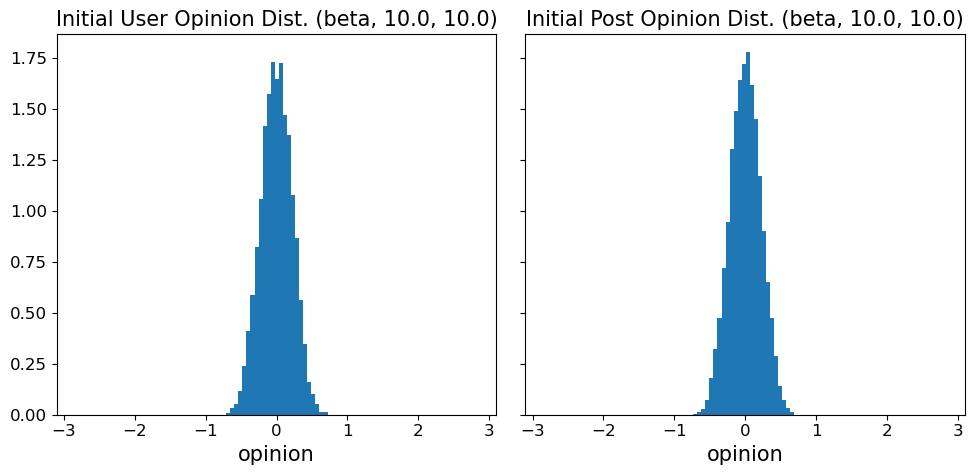

In [4]:
##### user distribution parameter #####
user_N = 10**4
user_dist_type = 'beta'
user_dist_type_params = [10, 10]

##### post distribution parameter #####
post_N = 10**4
post_dist_type = 'beta'
post_dist_type_params = [10, 10]

##### opinion dynamics parameter #####
parameter = set_parameter(mu=0.1, epsilon=0.425, reject_scale=1, interaction_width=0.7, leave_prob=0, join_rate=0, border=3, reset_alpha=5, reset_beta=5)

##### create and plot initial distributions #####
user_opinion = opinion_dist(user_N, user_dist_type, user_dist_type_params)
post_opinion = opinion_dist(post_N, post_dist_type, post_dist_type_params)

init_user_opinion = np.copy(user_opinion)

n_bins = 25
plot_initial_state(user_opinion, post_opinion, parameter[6], n_bins)
total_runtime = 0

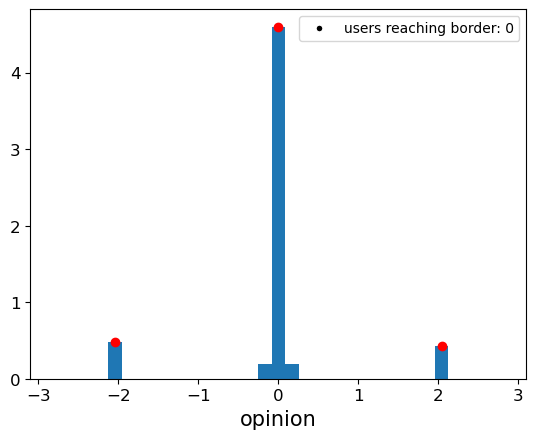

Amount of users: 10000
peaks: 3
total runtime: 1e+07
CPU times: user 2.27 s, sys: 192 ms, total: 2.46 s
Wall time: 2.47 s


In [5]:
%%time
##### run simulation #####

simulation_time = 10**7
freq_step = 10**2
user_opinion, timelines, N_reset, reset_freq, rejection_freq, attraction_freq, ignorance_freq, all_weights = opinion_dynamics(user_opinion, post_opinion, 
                                                                                                                              simulation_time, parameter, freq_step)
total_runtime += simulation_time

plot_final_state(user_opinion, N_reset, parameter[6], n_bins)
print('total runtime: %g' %total_runtime)

In [6]:
check_stability(user_opinion, 0.25, n_bins)

1

#repulsion/#attraction = 0.25
#ignorance/#repulsion = 0


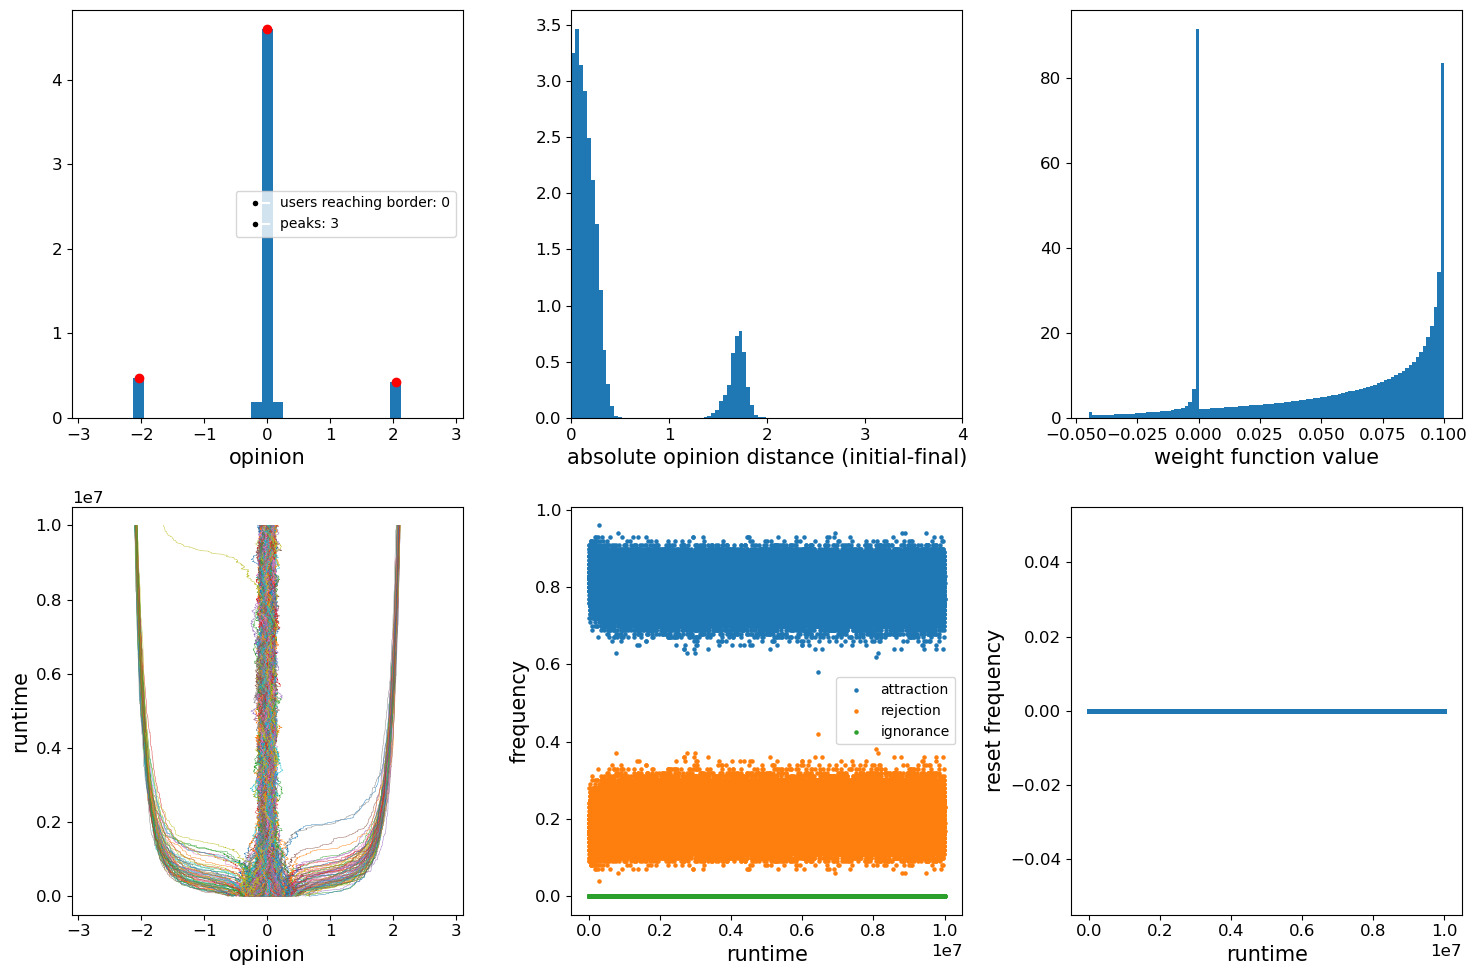

In [7]:
plot_all(simulation_time, init_user_opinion, user_opinion, N_reset, parameter[6], 0, 1000, timelines, 
         reset_freq, rejection_freq, attraction_freq, ignorance_freq, freq_step, all_weights, n_bins)

In [14]:
##### loop for further parameter analysis #####

##### user distribution parameter #####
user_N = 10**4
user_dist_type = 'beta'
user_dist_type_params = [10, 10]

##### post distribution parameter #####
post_N = 10**4
post_dist_type = 'beta'
post_dist_type_params = [10, 10]

step_mu = np.arange(0.1, 0.51, 0.2)
step_eps = np.arange(0.25, 0.76, 0.25)

rows = len(step_mu)
columns = len(step_eps)

simulation_time = 10**7
freq_step = 10**7

data = np.zeros((rows, columns, user_N))

for i in range(rows):
    for j in range(columns):
        user_opinion = opinion_dist(user_N, user_dist_type, user_dist_type_params)
        post_opinion = opinion_dist(post_N, post_dist_type, post_dist_type_params)
        parameter = set_parameter(mu=step_mu[i], epsilon=step_eps[j], reject_scale=1, interaction_width=0.7, leave_prob=0, join_rate=0, border=2, reset_alpha=5, reset_beta=5)
        data[i,j], timelines, N_reset, reset_freq, rejection_freq, attraction_freq, ignorance_freq, all_weights = opinion_dynamics(user_opinion, post_opinion, 
                                                                                                                                   simulation_time, parameter, freq_step)
        print(f"{i+1}/{rows} {j+1}/{columns}", end='\r')
#np.save('varying_mu(%0.2f-%0.2f)_eps(%0.2f-%0.2f)_%0.1f_%0.1f_%0.1f_%0.1f'%(np.amin(step_mu), np.amax(step_mu), np.amin(step_eps), np.amax(step_eps), user_dist_type_params[0],user_dist_type_params[1],post_dist_type_params[0],post_dist_type_params[1]), data)        

In [ ]:
#data = np.load('')

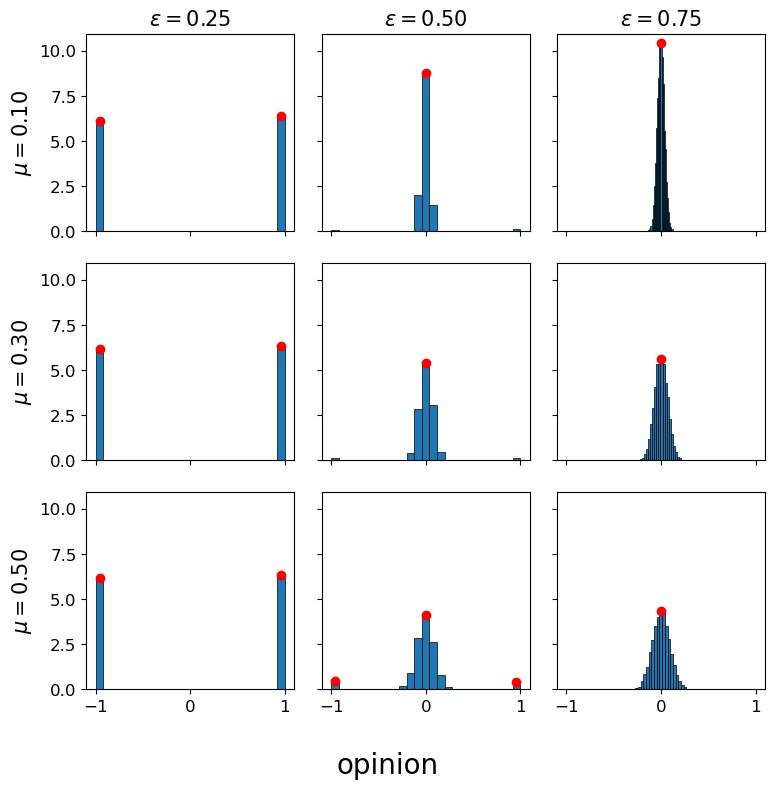

In [15]:
fig, axs = plt.subplots(rows, columns, sharey=True, sharex=True,figsize=(8,8))   

for i in range(rows):
    for j in range(columns):
       
        axs[i,j].hist(data[i,j], density=True, bins=n_bins, ec='black', lw=0.5)
        peaks_x, peaks_y, n_peaks = peak_finder(data[i,j], n_bins)
        axs[i,j].scatter(peaks_x, peaks_y, color='red')

#fig.suptitle('init. u.d. (%s, %0.1f, %0.1f), init. p.d. (%s, %0.1f, %0.1f)\n reject scale=%0.2f, interaction width=%0.2f, leave prob=%0.2f\n join rate=%0.2f, border=%0.2f, reset alpha=%0.2f, reset beta=%0.2f\n simulation time=%0.1g'
#             %(user_dist_type,user_dist_type_params[0],user_dist_type_params[1],post_dist_type,post_dist_type_params[0],post_dist_type_params[1],
#               parameter[2],parameter[3],parameter[4],parameter[5],parameter[6],parameter[7],parameter[8], simulation_time))

for i in range(rows):
    axs[i,0].set_ylabel(r'$\mu=%0.2f$'%(step_mu[i]))

for j in range(columns):
    axs[0,j].set_title(r'$\varepsilon=%0.2f$'%(step_eps[j]))

fig.supxlabel('opinion')
#plt.savefig('varying_mu(%0.2f-%0.2f)_eps(%0.2f-%0.2f)_%0.1f_%0.1f_%0.1f_%0.1f.pdf'%(np.amin(step_mu), np.amax(step_mu), np.amin(step_eps), np.amax(step_eps), user_dist_type_params[0],user_dist_type_params[1],post_dist_type_params[0],post_dist_type_params[1]), bbox_inches='tight')
#plt.savefig('RW_final_dist.png', dpi=200, bbox_inches='tight')
plt.tight_layout()

In [56]:
##### heatmap of peaks #####

##### user distribution parameter #####
user_N = 10**4
user_dist_type = 'beta'
user_dist_type_params = [10, 10]

##### post distribution parameter #####
post_N = 10**4
post_dist_type = 'beta'
post_dist_type_params = [10, 10]

step_mu = np.around(np.arange(0.1, 41, 0.025), decimals=3)
step_eps = np.around(np.arange(0.3, 0.61, 0.025), decimals=3)

rows = len(step_mu)
columns = len(step_eps)

#simulation_time = 10**7
freq_step = 10**12

map_data = np.zeros((rows, columns))
stability = np.zeros((rows, columns))

for i in range(rows):
    for j in range(columns):
        user_opinion = opinion_dist(user_N, user_dist_type, user_dist_type_params)
        post_opinion = opinion_dist(post_N, post_dist_type, post_dist_type_params)
        parameter = set_parameter(mu=step_mu[i], epsilon=step_eps[j], reject_scale=1, interaction_width=0.7, leave_prob=0, join_rate=0, border=2, reset_alpha=5, reset_beta=5)
        
        while check_stability(user_opinion, 0.25, n_bins) > 10:
            user_opinion, timelines, N_reset, reset_freq, rejection_freq, attraction_freq, ignorance_freq, all_weights = opinion_dynamics(user_opinion, post_opinion, 
                                                                                                                                          simulation_time, parameter, freq_step)
        
        peaks_x, peaks_y, n_peaks = peak_finder(user_opinion, n_bins)
        map_data[i,j] = n_peaks
        stability[i,j] = check_stability(user_opinion, 0.25, n_bins)
        
        print(f"{i+1}/{rows} \t {j+1}/{columns}", end='\r')

In [69]:
#np.save('heatmap_mu_eps_(0.1-1)_10_10_10_10_runtime_20e7_stability', map_data)
#np.save('heatmap_mu_eps_(0.1-1)_10_10_10_10_runtime_20e7_stability_data', stability)

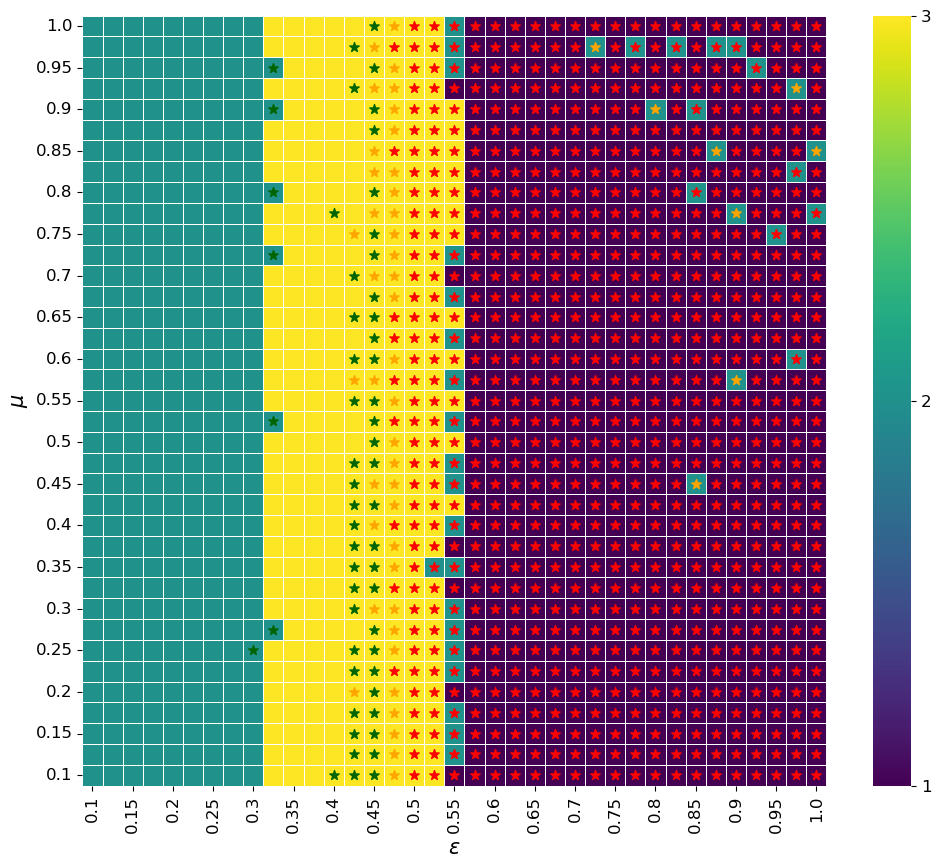

In [57]:
plt.figure(figsize=(12,10))
ax = sns.heatmap(map_data, cmap='viridis', linewidths=0.5, cbar_kws={"ticks":np.arange(np.amax(map_data)+1)})

ax.set_xticks(np.arange(columns)[::2]+0.5)
ax.set_yticks(np.arange(rows)[::2]+0.5)
ax.set_xticklabels(step_eps[::2])
ax.set_yticklabels(step_mu[::2])
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel(r'$\mu$')
for i in range(rows):
    for j in range(columns):
        
        if stability[i,j] >= 1000:
            ax.scatter(j+0.5,i+0.5, marker='*', color='red', s=50)
        elif stability[i,j] >= 500:
            ax.scatter(j+0.5,i+0.5, marker='*', color='orange', s=50)
        elif stability[i,j] >= 100:
            ax.scatter(j+0.5,i+0.5, marker='*', color='darkgreen', s=50)    
            #ax.text(j+0.5,i+0.5, '%i' %stability[i,j], color='red', va='center', ha='center', size=20)
        

plt.gca().invert_yaxis()
plt.savefig('a100_trunc_heatmap_mu_eps_(0.1-1)_10_10_10_10_runtime_1e7_stability.pdf', bbox_inches='tight') #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
plt.show()

In [3]:
##### loop for further parameter analysis #####

##### user distribution parameter #####
user_N = 10**3
user_dist_type = 'beta'
user_dist_type_params = [10, 10]

##### post distribution parameter #####
post_N = 10**4
post_dist_type = 'beta'
post_dist_type_params = [10, 10]

simulation_time = 10**6
freq_step = 10**2
n_bins = 25

step_eps = np.arange(0.25, 0.751, 0.25)
rows = len(step_eps)

data = np.zeros((rows, user_N))
timelines = np.zeros((rows, 1000, int(simulation_time/freq_step)))
stability = np.zeros(rows)

for i in range(len(step_eps)):
    
    user_opinion = opinion_dist(user_N, user_dist_type, user_dist_type_params)
    post_opinion = opinion_dist(post_N, post_dist_type, post_dist_type_params)
    parameter = set_parameter(mu=0.5, epsilon=step_eps[i], reject_scale=1, interaction_width=0.7, leave_prob=0, join_rate=0, border=2, reset_alpha=5, reset_beta=5)
    data[i], timelines[i], N_reset, reset_freq, rejection_freq, attraction_freq, ignorance_freq, all_weights = opinion_dynamics(user_opinion, post_opinion, 
                                                                                                                               simulation_time, parameter, freq_step)
    
    stability[i] = check_stability(user_opinion, 0.25, n_bins)

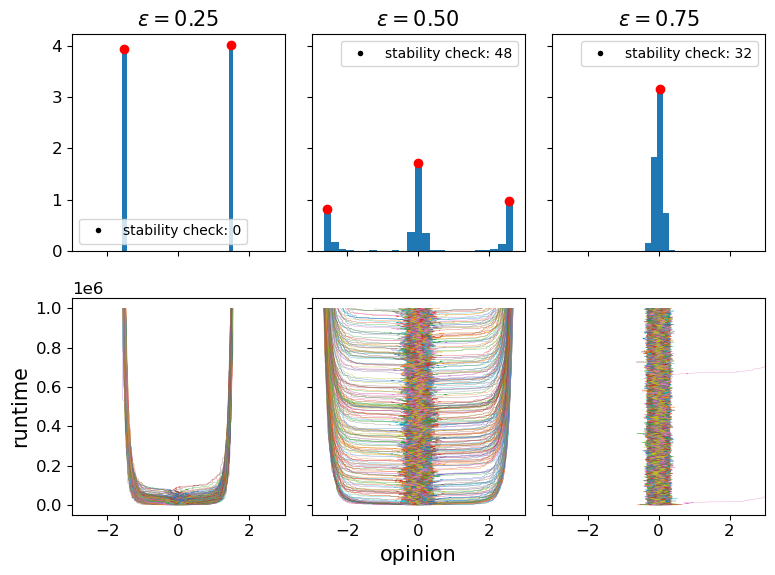

In [4]:
x = np.arange(0, simulation_time, freq_step)
t = np.arange(0, int(simulation_time/freq_step), 1)

fig, axs = plt.subplots(2, len(step_eps), sharey='row', sharex=True, figsize=(8,6))   

for i in range(len(step_eps)):
    legend_element = [Line2D([0], [0], marker='o', color='w', label='stability check: %g'%stability[i], markerfacecolor='black', markersize=5)]

    peaks_x, peaks_y, n_peaks = peak_finder(data[i], n_bins)
    
    axs[0,i].hist(data[i], density=True, bins=n_bins)
    axs[0,i].scatter(peaks_x, peaks_y, color='red')
    axs[0,i].legend(handles=legend_element, loc='best')
    axs[0,i].set_title(r'$\varepsilon=%0.2f$'%(step_eps[i]))
    
    for k in range(0, 999):
        axs[1,i].plot(timelines[i][k, t], x, linewidth = 0.2, alpha=1)
    
    axs[1,1].set_xlabel("opinion")
    axs[1,0].set_ylabel("runtime")
    axs[0,0].set_xlim([-3,3])

#plt.savefig('stability_check_example.png', dpi=200, bbox_inches='tight')
plt.tight_layout()